# CAPITULO 1: 

## Propuesta avance 2 -Análisis de Series Temporales: Promedio Móvil, Rezagos y estacionalidad

In [ ]:
# ======================================================
# 🔒 Ocultar todo el código en Colab y al subir a GitHub
# ======================================================
from IPython.display import HTML, display

display(HTML('''
<style>
/* Oculta las celdas de código y sus etiquetas */
div.input, div.output_prompt, div.prompt {
    display: none !important;
}
/* Deja visibles las salidas (gráficas, texto, tablas) */
div.output_area {
    display: block !important;
}
</style>
'''))


In [2]:


# ======================================================
# 📊 ANÁLISIS DE SERIES TEMPORALES - CAFÉ EN COLOMBIA
# ======================================================

# Instalar dependencias necesarias
!pip install pandas matplotlib seaborn statsmodels

# ------------------------------------------------------
# Importar librerías
# ------------------------------------------------------
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf
from google.colab import files
import numpy as np

# ------------------------------------------------------
# Cargar archivo CSV desde el equipo
# ------------------------------------------------------
print("📁 Por favor, selecciona tu archivo CSV (por ejemplo: FAOSTAT_Produccion_Agricola_Extendida.csv)")
uploaded = files.upload()
filename = list(uploaded.keys())[0]
print(f"✅ Archivo cargado correctamente: {filename}")

# Leer el archivo
df = pd.read_csv(filename)
print("✅ Datos cargados correctamente.\n")
display(df.head())

# ------------------------------------------------------
# Configuración general
# ------------------------------------------------------
sns.set(style="whitegrid")
plt.rcParams.update({'font.size': 11})

# ------------------------------------------------------
# Filtrar datos: Colombia - Café
# ------------------------------------------------------
df_colombia = df[(df["Pais"] == "Colombia") & (df["Producto"] == "Coffee")].copy()
df_colombia["Año"] = pd.to_datetime(df_colombia["Año"], format="%Y")
df_colombia.set_index("Año", inplace=True)

variables = ["Produccion", "Consumo", "Exportaciones"]

# Escalado (millones)
df_scaled = df_colombia.copy()
for col in variables:
    df_scaled[col] = df_colombia[col] / 1_000_000  # en millones

# ======================================================
# 🔹 BLOQUE 1: Series originales + Promedio móvil
# ======================================================
fig, axes = plt.subplots(1, len(variables), figsize=(18, 5))
fig.suptitle("Series Originales y Promedios Móviles - Café en Colombia", fontsize=14, weight="bold")

for i, var in enumerate(variables):
    ax = axes[i]
    ax.plot(df_scaled.index, df_scaled[var], label=f"{var} original", marker="o")
    ax.plot(df_scaled.index, df_scaled[var].rolling(window=5).mean(),
             label="Promedio móvil (5 años)", linestyle="--", color="orange")

    for x, y in zip(df_scaled.index, df_scaled[var]):
        if pd.notna(y):
            ax.text(x, y, f"{y:.2f}", fontsize=8, ha='left', va='bottom', rotation=45)

    ax.set_title(f"{var}", fontsize=12, weight="bold")
    ax.set_ylabel("Millones")
    ax.set_xlabel("Año")
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()


[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


ModuleNotFoundError: No module named 'google.colab'

Las series temporales de producción, consumo y exportaciones de café en Colombia evidencian una marcada variabilidad interanual, con fluctuaciones cíclicas y picos recurrentes que reflejan la naturaleza estacional del cultivo y la influencia de factores externos como el clima y los precios internacionales. El promedio móvil de cinco años suaviza la serie y permite identificar una tendencia general estable, con leves fases de recuperación en los últimos periodos, lo que sugiere cierta resiliencia estructural del sector cafetero frente a las variaciones de corto plazo.

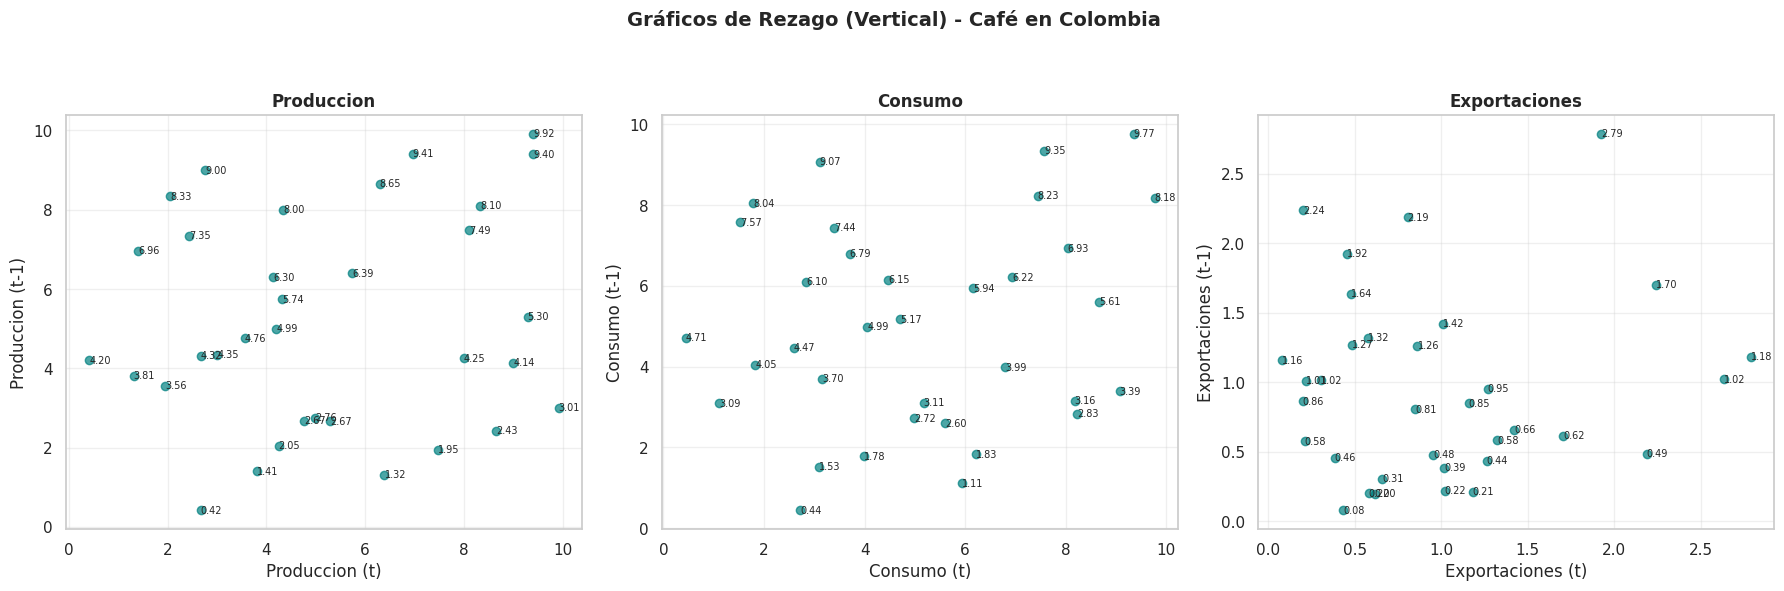

In [ ]:
# ======================================================
# 🔹 BLOQUE 2: Gráficos de Rezago (t vs t-1)
# ======================================================
fig, axes = plt.subplots(1, len(variables), figsize=(18, 6))
fig.suptitle("Gráficos de Rezago (Vertical) - Café en Colombia", fontsize=14, weight="bold")

for i, var in enumerate(variables):
    ax = axes[i]
    x_vals = df_scaled[var]
    y_vals = df_scaled[var].shift(1)
    ax.scatter(x_vals, y_vals, color='teal', alpha=0.7)

    for x, y in zip(x_vals, y_vals):
        if pd.notna(x) and pd.notna(y):
            ax.text(x, y, f"{y:.2f}", fontsize=7, ha='left', va='center')

    ax.set_title(f"{var}", fontsize=12, weight="bold")
    ax.set_xlabel(f"{var} (t)")
    ax.set_ylabel(f"{var} (t-1)")
    ax.grid(True, alpha=0.3)

plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()

Los gráficos de rezago permiten examinar la relación entre los valores actuales y los del periodo previo en cada variable, para este caso, en las series de producción, consumo y exportaciones de café, se observa una dispersión moderada con una ligera alineación ascendente, lo que sugiere cierta persistencia temporal: los niveles altos de un año tienden a mantenerse en el siguiente. Sin embargo, la amplitud del rango y la ausencia de una concentración fuerte indican que el comportamiento anual presenta también componente aleatorio y choques externos, propios de mercados agrícolas sensibles a condiciones climáticas y de demanda internacional.

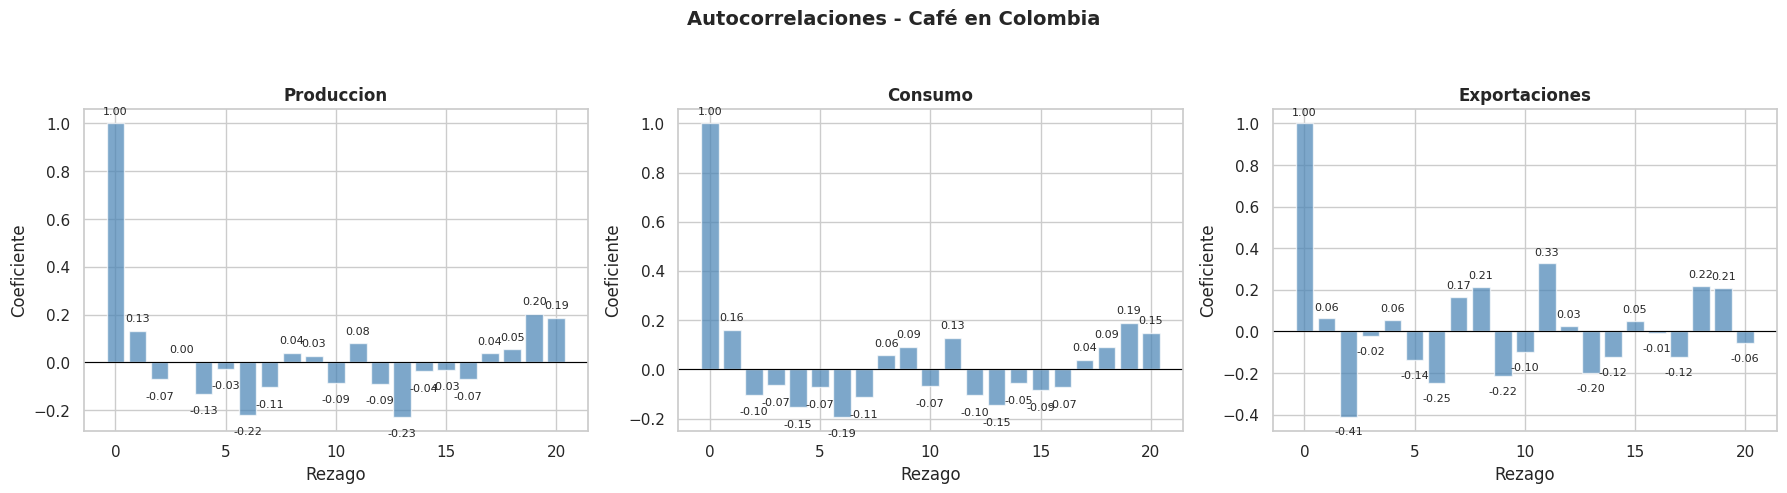

In [ ]:
# ======================================================
# 🔹 BLOQUE 3: Autocorrelación
# ======================================================
fig, axes = plt.subplots(1, len(variables), figsize=(18, 5))
fig.suptitle("Autocorrelaciones - Café en Colombia", fontsize=14, weight="bold")

for i, var in enumerate(variables):
    ax = axes[i]
    series = df_scaled[var].dropna()
    acf_vals = acf(series, nlags=20, fft=False)

    ax.bar(range(len(acf_vals)), acf_vals, color='steelblue', alpha=0.7)
    ax.axhline(0, color='black', linewidth=0.8)
    ax.set_title(f"{var}", fontsize=12, weight="bold")
    ax.set_xlabel("Rezago")
    ax.set_ylabel("Coeficiente")

    for j, val in enumerate(acf_vals):
        ax.text(j, val + (0.03 if val >= 0 else -0.05), f"{val:.2f}",
                 ha='center', va='bottom' if val >= 0 else 'top', fontsize=8)

plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()


Los resultados de la función de autocorrelación (ACF) evidencian que las series de producción, consumo y exportaciones de café presentan una dependencia temporal baja a moderada en los primeros rezagos, seguida de una rápida atenuación hacia valores cercanos a cero. Este patrón indica que los efectos de un año sobre el siguiente son transitorios, sin persistencia significativa en el largo plazo. La presencia de algunos rezagos positivos aislados sugiere fluctuaciones cíclicas débiles, propias de dinámicas agrícolas influenciadas por factores climáticos y de mercado, más que por un componente autoregresivo estructural fuerte.

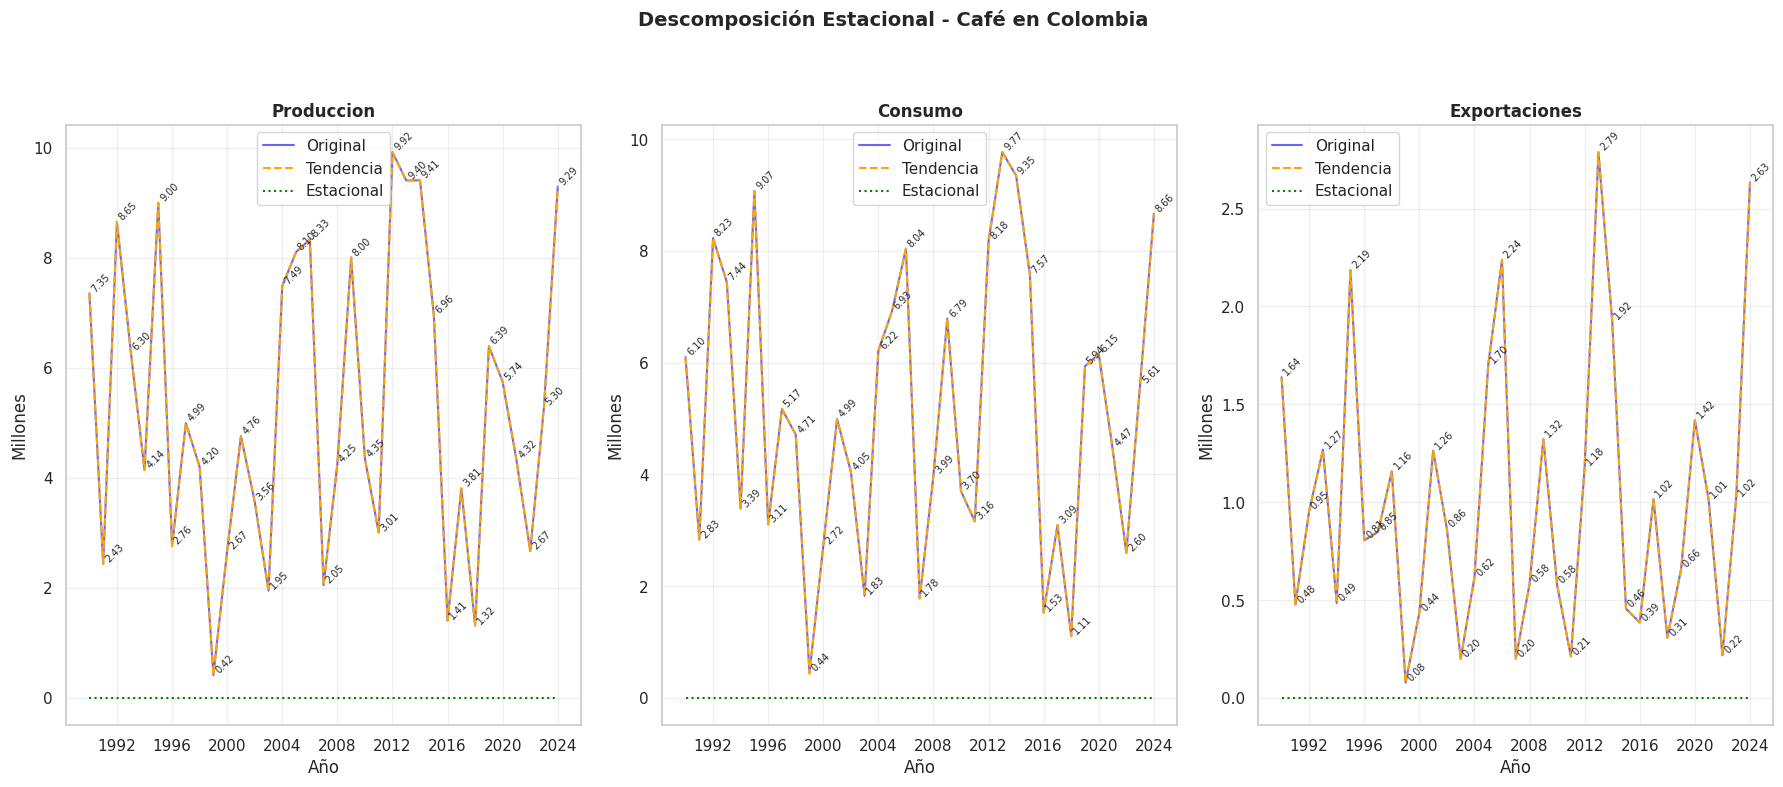

In [ ]:
# ======================================================
# 🔹 BLOQUE 4: Descomposición Estacional (Horizontal)
# ======================================================
fig, axes = plt.subplots(1, len(variables), figsize=(18, 8))
fig.suptitle("Descomposición Estacional - Café en Colombia", fontsize=14, weight="bold")

for i, var in enumerate(variables):
    decomposition = seasonal_decompose(df_scaled[var], model='additive', period=1)
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    resid = decomposition.resid

    ax = axes[i]
    ax.plot(df_scaled.index, df_scaled[var], label="Original", color="blue", alpha=0.6)
    ax.plot(df_scaled.index, trend, label="Tendencia", color="orange", linestyle="--")
    ax.plot(df_scaled.index, seasonal, label="Estacional", color="green", linestyle=":")

    # Agregar etiquetas de valores en la tendencia
    for x, y in zip(df_scaled.index, trend):
        if pd.notna(y):
            ax.text(x, y, f"{y:.2f}", fontsize=7, ha='left', va='bottom', rotation=45)

    ax.set_title(f"{var}", fontsize=12, weight="bold")
    ax.set_xlabel("Año")
    ax.set_ylabel("Millones")
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()

La descomposición estacional de las series de producción, consumo y exportaciones de café en Colombia revela que las fluctuaciones observadas están dominadas por el componente de tendencia, reflejando variaciones estructurales de largo plazo más que estacionales. El componente estacional muestra una amplitud mínima y estable, lo que sugiere que los patrones recurrentes anuales tienen una influencia marginal frente a los cambios de tendencia asociados a factores económicos, productivos o climáticos. En conjunto, los resultados indican que las dinámicas del sector cafetero colombiano responden principalmente a variaciones de tendencia y choques transitorios, más que a una estacionalidad marcada o predecible.

## Conclusiones generales

En la producción de café en toneladas cada 10 años se encuentra un pico alto, igual sucede para el consumo, las exportaciones y el precio promedio. El análisis de promedio móvil suaviza la serie y se mantiene los picos cada 10 años para la producción, el consumo, las exportaciones, para el promedio precio promedio se suavizan a solo dos picos altos en 2001 y 2014, con respecto al gráfico de rezagos en la producción de café se observan dos clústeres a izquierda y derecha de una recta imaginaria con pendiente positiva que indica que la producción aumenta, igual sucede con el consumo, en las exportaciones se observa un gran clúster de datos abajo de la recta y = 1.5 y unos datos atípicos por encima de la recta citada, en el precio promedio un gran cluster abajo del punto (600,600) y datos dispersos por encima del punto y a la derecha del punto. Las cuatro variables muestran una correlación baja entre -0,25 y 0,25, y alrededor de y = 0, (sin autocorrelación). El análisis de estacionalidad para la producción de café y el consum muestra una tendencia por abajo de 10M, exportaciones por abajo de 3M y un precio promedio para cada quinquenio por abajo de 800 US $.

Identificar los períodos decenales de picos altos puede explicarse con situacones políticas, económicas, sociala o ambientales del mercado lo que permite plantear politicas a largo plazo.

Los dos picos altos en el promedio móvil indica una mauor volatilidad. Los clústeres que se encuentran indican relaciones lineales entre las variables, y la dispersión en el precio promedio muestra la incidencia de factores externos como los ya citados.

Por otra parte, el café, es un cultivo que depende de las lluvias para cubrir sus necesidades hídricas. Cuando la planta de café es sometida a un exceso de agua, la asimilación de esta se hace poco eficiente afectado el así la productividad (Rodríguez, Y.L. et al, 2012). Las lluvias en Colombia son afectadas por un ciclo de la naturaleza conocido como fenómeno del niño y la niña, donde este último genera un aumento de las precipitaciones. En los años 1998,1999,2000, 2007, 2008, 2010 y 2011 la niña se intensifico (Schreck C.J.B, 2024) como consecuencia hubo un aumento de lluvias, por eso se puede observar las caídas en el grafico de producción de café en Colombia , las cuales van de la mano con el consumo y la exportación, caso contrario, el precio se vio favorecido cuando se presentó este fenómeno.

Rodríguez, Y. L., & Pabón, J. D. (2012). La variabilidad climática interanual asociada al ciclo El Niño-La Niña-Oscilación del Sur y su efecto en el clima de Colombia. Revista de la Academia Colombiana de Ciencias Exactas, Físicas y Naturales, 36(140), 421-435. http://www.scielo.org.co/scielo.php?pid=S2011-21732012000100009&script=sci_arttext

Schreck, C. J. B. (s.f.). El Niño - Southern Oscillation (ENSO). GGWeather. Recuperado 22 de mayo de 2024, de https://ggweather.com/enso/oni.htm
